In [1]:
import colorcet as cc
import matplotlib.pyplot as plt
import mnist
import numpy as np
import scipy.spatial.distance

# First test: dumb

In [3]:
N = int(1e5) # number of points

In [4]:
D = int(1e2) # dimension of feature space

First, just let $X$ consist of a bunch of Gaussian iid random vectors (i.e. $X$ is an $N \times D$ Gaussian random matrix iid entries). This should a very easy case because the data should be more or less radially distributed around $\langle x_i \rangle = 0$.

In [5]:
X = np.random.randn(N, D)

Choose a random symmetric positive definite matrix (not uniformly, but from some distribution... not exactly sure which)

In [10]:
A = np.random.rand(D, D)
A = A.T@A

Transform the data matrix accordingly (i.e., $x_i \gets Ax_i$)

In [11]:
X = X@A

Sample $p$, defined to be the fraction of data points arbitrarily on one side of a hyperplane selected uniformly at random.

In [12]:
def sample_p(X):
    N, D = X.shape
    X_mean = np.mean(X, axis=0)
    nu = np.random.randn(D) # pick a random direction
    I = (X - X_mean)@nu >= 0
    p = I.sum()/N # percent on one side of the hyperplane
    return p, I

In [13]:
p, I = sample_p(X)

In [19]:
%%time
P = np.array([sample_p(X)[0] for _ in range(100)])

CPU times: user 6.36 s, sys: 1.02 s, total: 7.38 s
Wall time: 4.24 s


Plot a histogram of the sampled $p$ values. **Note**: we plot on the interval $[0.4995, 0.5005]$, because otherwise the samples are concentrated too tightly to see!

(0.4995, 0.5005)

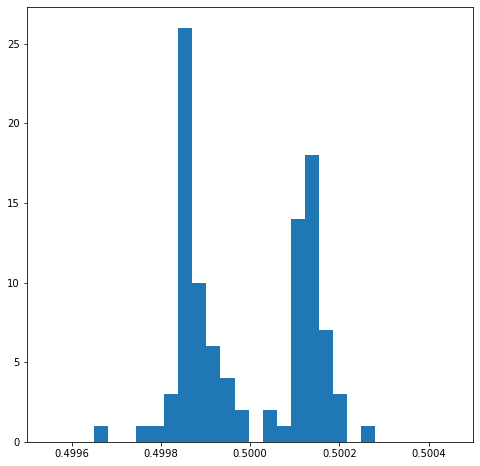

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.hist(P, bins=20)
ax.set_xlim(0.4995, 0.5005)

# Second test: MNIST

Download some images (just get the training images for now)

In [29]:
Xm = mnist.train_images().astype(np.float64)

Vectorize the images to get a data matrix

In [30]:
Xm = Xm.reshape(Xm.shape[0], np.prod(Xm.shape[1:]))

Plot the average image and the average vector

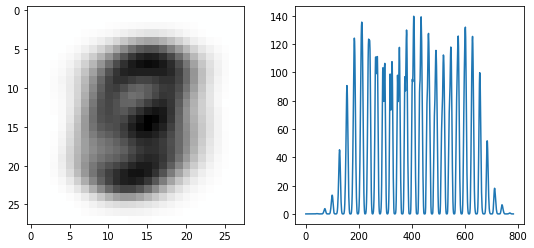

In [34]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)
ax.imshow(Xm.mean(axis=0).reshape(28, 28), cmap=cc.cm.gray_r)
ax = fig.add_subplot(122)
ax.plot(Xm.mean(axis=0).flatten())

Estimate $p$ using 1,000 samples

In [35]:
%%time
Pm = [sample_p(Xm) for _ in range(1000)]

Plot a histogram of $p$ on $[0.4, 0.6]$. It's much more spread out than the previous example, but still very reasonably concentrated around the mean

(0.4, 0.6)

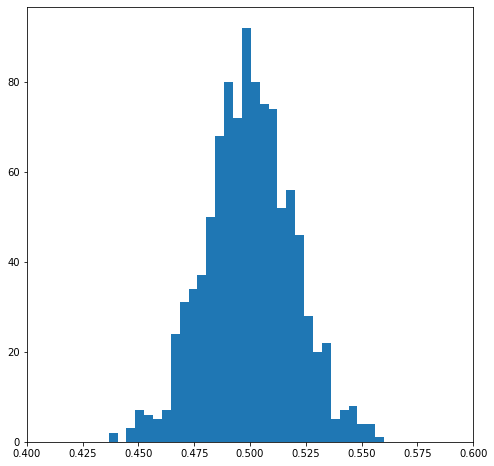

In [40]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.hist(Pm, bins=31)
ax.set_xlim(0.4, 0.6)

Now, let's try constructing a few levels of a random BSP tree 

In [45]:
def find_good_p(X, nit, verbose=False):
    p, I = sample_p(X)
    p_prev, I_prev = p, I
    ps = [p]
    for i in range(nit):
        if verbose:
            print(i)
        p, I = sample_p(X)
        if abs(p - 0.5) < abs(p_prev - 0.5):
            p_prev = p
            I_prev = I
        ps.append(p_prev)
    return p_prev, I, ps

In [53]:
%%time
p, I0 = find_good_p(Xm, 10)[:2]
print(f'Best p: {p}')

Best p: 0.4988166666666667
CPU times: user 3.3 s, sys: 2.48 s, total: 5.78 s
Wall time: 4.85 s


Extract the points on the $I_0$ side of the selected hyperplane

In [48]:
XmI0 = Xm[I0]

Let's take a look at the distribution of $p$ values for the points $x \in X_{I_0}$. It seems reasonable that the variance should be higher (on the other hand, since we have about half as many points to deal with, we can estimate $p$ for a given random hyperplane about twice as fast). For the histogram below, we use 100 samples an restrict the histogram to the interval $[0.4, 0.6]$.

In [49]:
%%time
PmI0 = [sample_p(XmI0)[0] for _ in range(100)]

(0.4, 0.6)

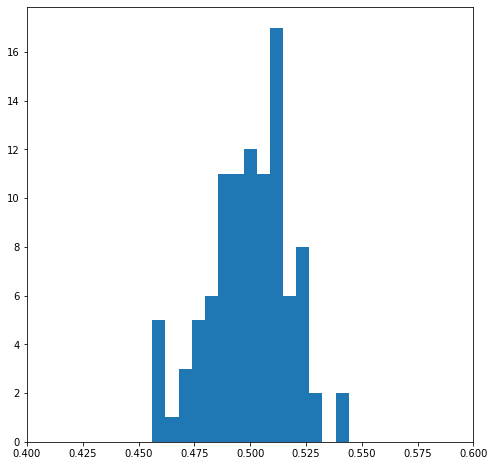

In [50]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.hist(PmI0, bins=15)
ax.set_xlim(0.4, 0.6)

Let's check out how long it takes to find a decent random hyperplane (for 10 trials)

In [52]:
%%time
p00, I00 = find_good_p(XmI0, 10)[:2]

CPU times: user 2.02 s, sys: 935 ms, total: 2.96 s
Wall time: 1.76 s


It takes around 2s versus the 5s it took to generate the parent hyperplane, as expected

# Conclusion

Creating a sort of randomized KD-tree/BSP tree using randomly selected hyperplanes seems to be feasible. At least for the MNIST data set, it doesn't appear to be too difficult to generate random directions that result in a good balance, suggesting that a tree with $O(\log N)$ height is attainable

# Next steps

## Find a problem to solve

Ideas:

- Applying spectral clustering to the MNIST data set using a Gaussian kernel
- others?

## Fast pairwise distance computations

In [ ]:
We should definitely just use the exact distance computations for a data set like MNIST, since the dataset is small enough that this won't take too long, but we'll want to compare this with using random projections a la Johnson-Lindenstrauss to speed this up. I'm not 100% sure what the best options are here. We'll need to compare the results carefully to the exact distance computations. Also, for nodes in the trees with enough points, the exact distance computations will be faster.